<a id='head'></a>
<a href='#fit_rf1'> Experiment 1 RandomForest Model</a>
    
<a href='#rf_hyper'> Experiment 2 Hyper parameter tuning with RF model</a>

# Data Preparation

In [58]:
import pandas as pd
import numpy as np

In [59]:
train_data = pd.read_csv('../data/raw/train.csv')
test_data = pd.read_csv('../data/raw/test.csv')
print(train_data.shape)
print(test_data.shape)

(8000, 22)
(3799, 21)


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')

test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)

X_data, X_test, y_data, y_test = train_test_split(df_train_scaled, train_data_target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print(train_data.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(8000, 22)
(5120, 19)
(1280, 19)
(1600, 19)


# Experiment 1 Fit RandomForests Model <a id='fit_rf1'></a>

In [61]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

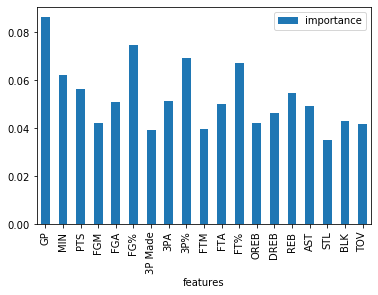

In [62]:
feature_imp = pd.DataFrame({'features':X_train.columns, 'importance':clf.feature_importances_})
feature_imp.plot.bar(x='features', y='importance')

In [63]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])

0.7077861785382676

### Majority of predictions are 1s

In [64]:
pred = clf.predict(X_test)
print(pred.shape)
print(np.sum(pred))

(1600,)
1570


# Experiment 2 Hyper parameter tuning with RF model <a id='rf_hyper'></a>

In [108]:
from sklearn.model_selection import RandomizedSearchCV

n_est = [int(x) for x in np.linspace(start=200, stop=2000, num=50)]
max_depth = [int(x) for x in np.linspace(2, 20, num=1)]
min_samples_split = [2,5,10]
bootstrap = [True, False]
class_weight = [None, 'balanced']

random_grid = {'n_estimators':n_est,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'bootstrap': bootstrap,
              'class_weight': class_weight}

In [109]:
clf = RandomForestClassifier()
rf_rcv = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_rcv.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [110]:
roc_auc_score(y_val, rf_rcv.predict_proba(X_val)[:,1])

0.7040447146104624

#### All predictions are 1s!

In [111]:
pred = rf_rcv.predict_proba(X_test)[:,1]
predx = [x for x in pred > 0.5]
print(f'{np.sum(predx)} out of {len(predx)} or {int(round(np.sum(predx)/len(predx)*100,0))}% of players are predicted to be 5+ Yrs')
print(f'ROC_AUC Score: {round(roc_auc_score(y_test, pred),3)}')

1600 out of 1600 or 100% of players are predicted to be 5+ Yrs
ROC_AUC Score: 0.71


#### Add thresthold to force 0s in data

In [112]:
thr = 0.8
pred = rf_rcv.predict_proba(X_train)[:,1]
predx = [x for x in pred > thr]
print(f'{np.sum(predx)} out of {len(predx)} or {int(round(np.sum(predx)/len(predx)*100,0))}% of players are predicted to be 5Yrs')
print(f'ROC_AUC Score: {round(roc_auc_score(y_train, pred),3)}')

3587 out of 5120 or 70% of players are predicted to be 5Yrs
ROC_AUC Score: 0.695


In [113]:
thr = 0.8
pred = rf_rcv.predict_proba(X_val)[:,1]
predx = [x for x in pred > thr]
print(f'{np.sum(predx)} out of {len(predx)} or {int(round(np.sum(predx)/len(predx)*100,0))}% of players are predicted to be 5Yrs')
print(f'ROC_AUC Score: {round(roc_auc_score(y_val, pred),3)}')

926 out of 1280 or 72% of players are predicted to be 5Yrs
ROC_AUC Score: 0.704


# Experiment 3 over sample with RF model